# Progetto di analisi e clusterizzazione di transazioni bitcoin
In questo progetto ho analizzato le transazioni bitcoin fino a dicembre 2012. Ho prodotto dei plot e clusterizzato i wallet addresses e tentato di deanonimizzare i wallet dei 10 cluster piu' grandi utilizzando due siti diversi su cui fare scraping.
Come prima cosa carico in 4 diversi dataframes i datasets forniti, dando un nome alle colonne utilizzando names=[ columns ] durante il caricamento dei csv

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# constant to convert satoshis in btc
SATOSHIS_IN_BTC = 100000000
# get current working directory to locate the datasets folder where datasets are kept
current_dir = os.getcwd()

# open all datasets
transactions = pd.read_csv(current_dir + "/datasets/transactions.csv", names=["timestamp", "blockId", "txId", "isCoinbase", "fee"])
inputs       = pd.read_csv(current_dir + "/datasets/inputs.csv", names=["txId", "prevTxId", "prevTxPos"])
outputs      = pd.read_csv(current_dir + "/datasets/outputs.csv", names=["txId", "position", "addressId", "amount", "scriptType"])
mapping      = pd.read_csv(current_dir + "/datasets/mapAddr2Ids8708820.csv", names=["hash", "addressId"])


Come prima analisi veniva richiesto di fare un plot della distribuzione del numero di transazioni per blocco. Ho quindi usato un raggruppamento, usando la funzione `.groupby(col)` fornita da pandas, raggruppando per blockId e quindi contanto il numero di occorrenze, quindi quante volte occorre quel valore di blockId ed ottenendo il numero di transazioni per quel blocco, usando il metodo `size()` di pandas. In pandas e' possibile concatenare queste operazioni in una sola riga.

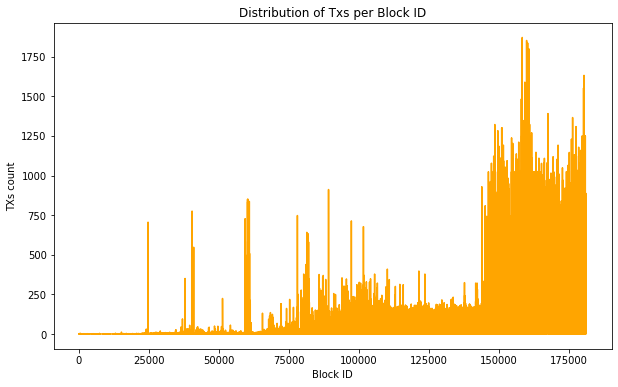

In [13]:
# count the occurrences of each blockId
tx_per_block_dist = transactions.groupby('blockId').size()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.plot(tx_per_block_dist.values, color="orange")
plt.xlabel("Block ID")
plt.ylabel("TXs count")
plt.title("Distribution of Txs per Block ID")
plt.show()

Per studiare l'andamento bimestrale del numero di transazioni medie tra il 2009 e il 2012 ho come prima cosa creato una lista di mesi usando pd.date_range, specificando la data di inizio, di fine e la frequenza (mensile). Fatto questo ho creato un dizionario in cui salvare i valori per ogni anno, ho creato i label per il plot dell'asse x (quindi i nomi di ogni bimestre). Infine iterando la lista di mesi con un passo pari a due ho usato la funzione `.between(start, end)` di pandas per ottenere una slice del dataframe con un constraint sul timestamp, sul dataframe ritornato ho eseguito una groupby su blockId come al passo prima ma stavolta ho calcolato `.mean()`. Ho quindi fatto un plot aggiungendo una linea per ogni anno salvato nel dizionario. Ho riportato sia la scala logaritmica per l'asse y, sia quella decimale, in quanto essendo le transazioni quasi uguali nel 2009 e 2010 non era facile distinguere le due linee utilizzando la scala decimale

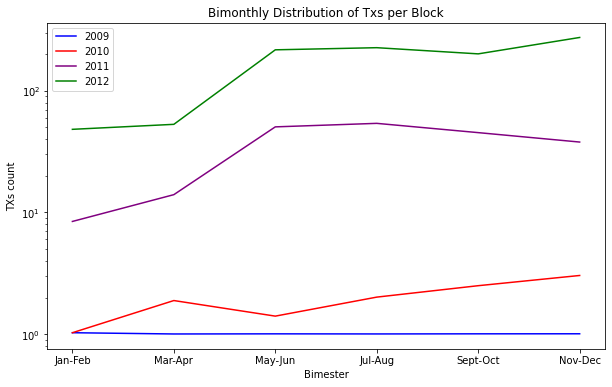

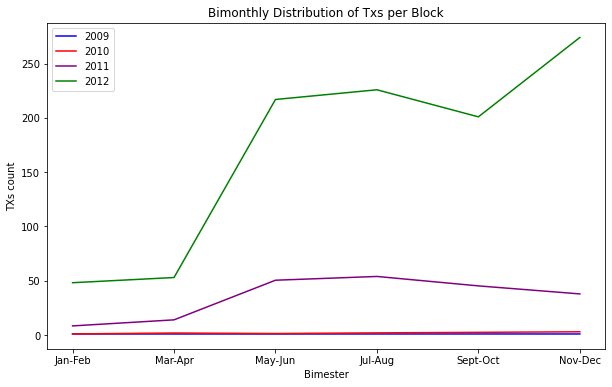

In [3]:
# get months list
months = pd.date_range(start="2009-01-01", end="2012-12-31", freq="M")
transactions['timestamp'] = pd.to_datetime(transactions["timestamp"], unit='s')

tx_dist_year = {"2009": [], "2010": [], "2011": [], "2012": []}
months_plot_label = ["Jan-Feb", "Mar-Apr", "May-Jun", "Jul-Aug", "Sept-Oct", "Nov-Dec"]

# iterate months and calculate mean block occupation
for i in range(0, len(months) - 1, 2):
    year = str(months[i].year)
    two_months_window = transactions[transactions["timestamp"].between(months[i], months[i+1])]
    two_months_window
    bimonthly_mean = two_months_window.groupby("blockId").size().mean()
    tx_dist_year[year].append(bimonthly_mean)

# Plot the data log scale
plt.figure(figsize=(10, 6))
plt.plot(months_plot_label, tx_dist_year["2009"], color="blue", label="2009")
plt.plot(months_plot_label, tx_dist_year["2010"], color="red", label="2010")
plt.plot(months_plot_label, tx_dist_year["2011"], color="purple", label="2011")
plt.plot(months_plot_label, tx_dist_year["2012"], color="green", label="2012")
plt.xlabel("Bimester")
plt.ylabel("TXs count")
plt.yscale("log")
plt.title("Bimonthly Distribution of Txs per Block")
plt.legend()
plt.show()

# decimal scale
plt.figure(figsize=(10, 6))
plt.plot(months_plot_label, tx_dist_year["2009"], color="blue", label="2009")
plt.plot(months_plot_label, tx_dist_year["2010"], color="red", label="2010")
plt.plot(months_plot_label, tx_dist_year["2011"], color="purple", label="2011")
plt.plot(months_plot_label, tx_dist_year["2012"], color="green", label="2012")
plt.xlabel("Bimester")
plt.ylabel("TXs count")
plt.title("Bimonthly Distribution of Txs per Block")
plt.legend()
plt.show()

Per calcolare gli UTXO (unspent transaction outputs) faccio una merge tra inputs e outputs. In particolare sto facendo una join su inputs utilizzando le colonne "prevTxId" e "prevTxPos", mentre su outputs sto facendo merge sulle colonne "txId" e "position" (aggiungo position, anche se non necessario, visto che la lunghezza di left e right deve essere la stessa), inner indica che la join mantiene soltanto le colonne che hanno valori corrispondenti nei datasets input e output. A questo punto per calcolare il valore totale di UTXO faccio la somma tra i valori in output e a questo valore sottraggo il totale della somma in input. Ho riportato anche una conversione da satoshi a btc (dividendo per `SATOSHIS_IN_BTC`)

In [4]:
# merge inputs and outputs to calculate utxo
merged = inputs.merge(outputs, left_on=["prevTxId", "prevTxPos"], right_on=["txId", "position"], how="inner")

# total output qty
total_outputs_btc_qty = outputs.amount.sum()
# total spent out qty
total_spent_btc_qty = merged.amount.sum()

# utxo is delta output and spent
utxo = total_outputs_btc_qty - total_spent_btc_qty

print(f"UTXO (satoshi): {utxo}")
print(f"UTXO (btc): {utxo/SATOSHIS_IN_BTC:.3f}")

UTXO (satoshi): 859303372614879
UTXO (btc): 8593033.726


Per calcolare la distribuzione degli intervalli di tempo tra transazioni che generano un valore in output e quelle che lo consumano creo 2 dataframes. 
1. spent_btc -> faccio una merge tra inputs e transazioni. Il dataframe risultante contiene, per ogni riga, una transazione in cui un output coincide con l'input e quindi viene speso
2. created_btc -> merge tra outputs e transazioni e contiene per ogni riga una transazione di quando e' stato creato un output
3. time_delta -> merge tra i due dataframe precedenti in modo da poter calcolare la colonna "ts_delta" = la differenza temporale tra transazione di spend e creazione.

Infine faccio come nel primo punto una group by sulla colonna calcolata e conto il numero di occorrenze facendono un plot

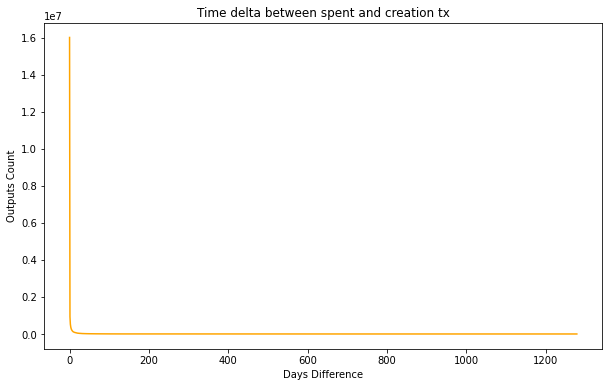

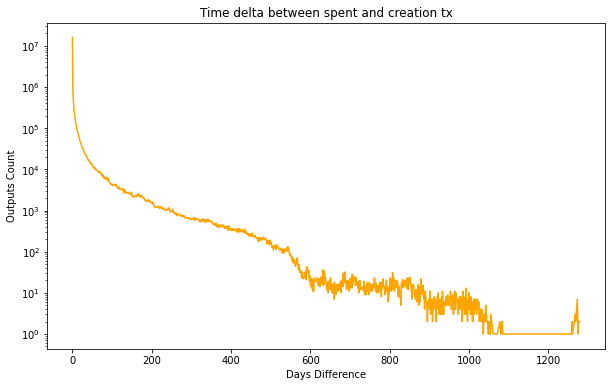

In [10]:
spent_btc = transactions.merge(inputs, on="txId")
spent_btc.rename(columns={"timestamp": "ts_spent_btc"}, inplace=True)

created_btc = transactions.merge(outputs, on="txId")
created_btc.rename(columns={"timestamp": "ts_created_btc", "txId": "outputTxId"}, inplace=True)

time_delta = spent_btc.merge(created_btc, how="inner", left_on=["prevTxId", "prevTxPos"], right_on=["outputTxId", "position"])

# calculate time delta
time_delta["ts_delta"] = (time_delta.ts_spent_btc - time_delta.ts_created_btc).dt.days
# filter rows where delta >= 0
time_delta = time_delta[time_delta["ts_delta"] >= 0]

df = time_delta.groupby("ts_delta")["prevTxId"].count()

# no log
plt.figure(figsize=(10, 6))
plt.plot(df.index, df.values, color="orange")
plt.title("Time delta between spent and creation tx")
plt.ylabel("Outputs Count")
plt.xlabel("Days Difference")
plt.show()

#log scale 
plt.figure(figsize=(10, 6))
plt.plot(df.index, df.values, color="orange")
plt.yscale("log")
plt.title("Time delta between spent and creation tx")
plt.ylabel("Outputs Count")
plt.xlabel("Days Difference")
plt.show()


Come analisi aggiuntiva ho studiato le fees. La prima analisi e' un plot delle fees pagate dal genesis block fino all'ultima transazione registrata nel dataset. Ho lasciato i quantitativi in satoshi in quanto ci sono poche transazioni con valori alti di fee

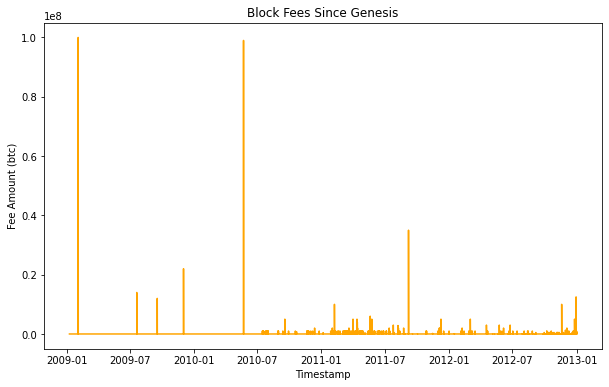

In [6]:
# get only these 4 columns and drop duplicates of the same block as the fee is the same for each line, keep the first
fees_df = transactions[["timestamp", "blockId", "txId","fee"]].drop_duplicates(subset="blockId", keep="first")
fees_df["timestamp"] = pd.to_datetime(fees_df["timestamp"], unit="s")

plt.figure(figsize=(10, 6))
plt.plot(fees_df.timestamp, fees_df.fee, color="orange")

# Title and xlabel
plt.title("Block Fees Since Genesis")
plt.ylabel("Fee Amount (btc)")
plt.xlabel("Timestamp")
plt.show()


La seconda analisi riguarda lo studio della distribuzione dei valori delle fees. E' possibile osservare che quasi tutte le fees sono pari a 0 o comunque molto basse, ~1 transazione ha fee comprese tra 0.2 e 0.4 (btc). Poco piu' di 2/3 transazioni hanno una fee >= 0.9 (btc)

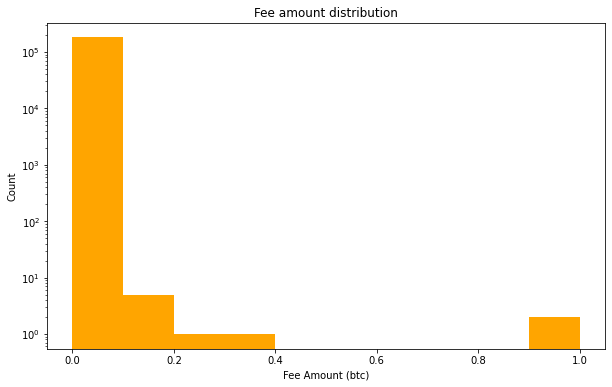

In [7]:

fees_df["btc_fee"] = fees_df["fee"]/SATOSHIS_IN_BTC
plt.figure(figsize=(10, 6))
plt.hist(fees_df.btc_fee, color="orange")
plt.title("Fee amount distribution")
plt.yscale("log")
plt.ylabel("Count")
plt.xlabel("Fee Amount (btc)")
plt.show()

Come ultima analisi delle fees ho fatto uno scatter plot per vedere se ci fosse una relazione tra il valore delle fees per blocco ed il numero di transazioni inserite in un blocco e ho osservato che questa relazione non esiste, rendendo fees per blocco e transazioni per blocco scorrelate

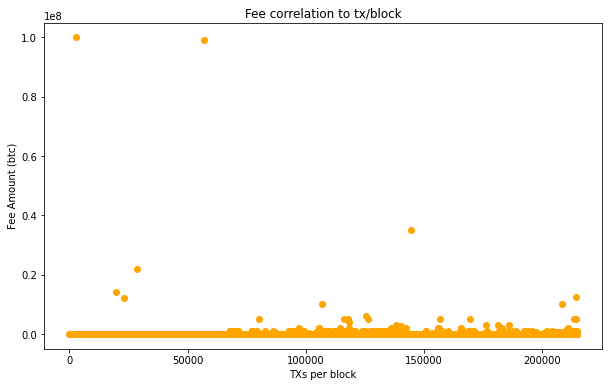

In [14]:
# convert series to dataframe, or join will fail
tx_per_block_dist = tx_per_block_dist.to_frame()
# create a df to store block count and fee value per block
fees_tx_dist = tx_per_block_dist.merge(fees_df, how="inner", on="blockId")

# fees dipendono dal numero di tx in blocco?
plt.figure(figsize=(10, 6))
plt.scatter(fees_tx_dist.blockId, fees_tx_dist.fee, color="orange")
plt.title("Fee correlation to tx/block")
plt.ylabel("Fee Amount (btc)")
plt.xlabel("TXs per block")
plt.show()


# Clustering
Per questa parte di progetto era richiesto di implementare un'euristica descritta nel paper allegato nella specifica ed usare un metodo di complessita' lineare presentato a lezione. Come prima cosa ho preparato i dataset. Cerco il numero di transazioni con input > 1. Ho quindi fatto un merge tra transazioni ed input, ho fatto una groupby su txId, selezionato la colonna "prevTxId" ed applicato `.count()` per avere il numero di input per tx. Ho quindi filtrato le transazioni con input > 1 e le ho salvate in effective_multi_input. Il dataframe in_out_merged contiene una merge tra transazioni con input > 1 e gli outputs, ho fatto una drop sulle colonne non necessarie ed infine una groupby su "txId" selezionando la colonna addressId.

## Creazione grafo
Ho creato un grafo diretto per modellare le transazioni. I nodi sono gli addressId trovati nel dataframe mapping (non ho usato la hash dell'indirizzo in quanto avrebbe appesantito il processo ed occupato molta memoria inutilmente, dato che ho un mapping hash <-> addressId nel dataframe mapping).

Infine ho aggiunto gli archi seguendo questi passi: 
1. Per ogni lista di indirizzi in multi_inputs, ho preso il primo elemento e ho aggiunto un arco verso ogni altro elemento presente nella lista
2. Aggiungo un arco soltanto se l'indirizzo sorgente e' diverso da quello destinazione in modo da non avere self loops

Ho quindi creato una lista di cluster usando la funzione `weakly_connected_components(graph)`, da questa lista ho calcolato le metriche richieste, quali dimensioni dei cluster, dimensione massima e minima dei cluster. Infine ho plottato la distribuzione delle dimensioni dei cluster.

In [16]:
import networkx as nx

# number of inputs for each txId (look at prevTxId duplicates)
input_tx_merged = transactions.merge(inputs, how="inner", on="txId")
inputs_count_per_tx = input_tx_merged.groupby("txId")["prevTxId"].count()

# filter inputs > 1 being the real multi input txId
effective_multi_input = inputs.loc[inputs["txId"].isin(inputs_count_per_tx.loc[inputs_count_per_tx.values > 1].index)]

# merge multi inputs with outputs, leave txId, addressId and amount per tx
in_out_merged = effective_multi_input.merge(outputs, left_on=["prevTxId", "prevTxPos"], right_on=["txId", "position"], how="inner")

in_out_merged.rename(columns={"txId_x": "txId"}, inplace=True)
# drop columns that are not used
in_out_merged.drop(['txId_y', "position", "prevTxId", "prevTxPos", "amount", "scriptType"], axis=1, inplace=True)


multi_inputs = in_out_merged.groupby("txId")['addressId']


# create direct graph
tx_graph = nx.DiGraph()

#use addressId else address is too big 
tx_graph.add_nodes_from(mapping["addressId"])

# iterate each group (txId) and add edge for each address that took place in the transaction
for txId, addresses in multi_inputs:
    # get source addess
    src_addr = addresses.iloc[0]

    # get destination addresses
    for dst_addr in addresses:

            if (not (src_addr == dst_addr)):
                tx_graph.add_edge(src_addr, dst_addr)

In [17]:
weakly_conn_components = nx.weakly_connected_components(tx_graph)
weakly_conn_components = list(weakly_conn_components)
"""per ogni txId mettere un arco verso tutti gli addressId che collega"""

# take top 10 clusters by size
clusters_size = [len(cluster) for cluster in weakly_conn_components]
ordered_clusters = sorted(weakly_conn_components, key = len, reverse = True)
sorted_clusters_size = [len(cluster) for cluster in ordered_clusters]
top10_clusters = ordered_clusters[:10]

for i in range(0,10):
    print(f"Clusters {i+1} size: {sorted_clusters_size[i]}")

#dimensione media, minima e massima dei cluster, distribuzione delle loro dimensioni
clusters_count = len(sorted_clusters_size)
mean_cluster_size = sum(sorted_clusters_size)/clusters_count
min_cluster_size = sorted_clusters_size[-1]
max_cluster_size = sorted_clusters_size[0]

# print results 
print("\n")
print(f"Numero clusters: {clusters_count}")
print(f"Nodi medi per cluster: {mean_cluster_size:.3}")
print(f"Nodi nel cluster piu' grande: {max_cluster_size}")
print(f"Nodi nel cluster piu' piccolo: {min_cluster_size}")

Clusters 1 size: 259773
Clusters 2 size: 121464
Clusters 3 size: 99645
Clusters 4 size: 76923
Clusters 5 size: 40969
Clusters 6 size: 30916
Clusters 7 size: 26615
Clusters 8 size: 20136
Clusters 9 size: 19894
Clusters 10 size: 16977


Numero clusters: 4800614
Nodi medi per cluster: 1.81
Nodi nel cluster piu' grande: 259773
Nodi nel cluster piu' piccolo: 1


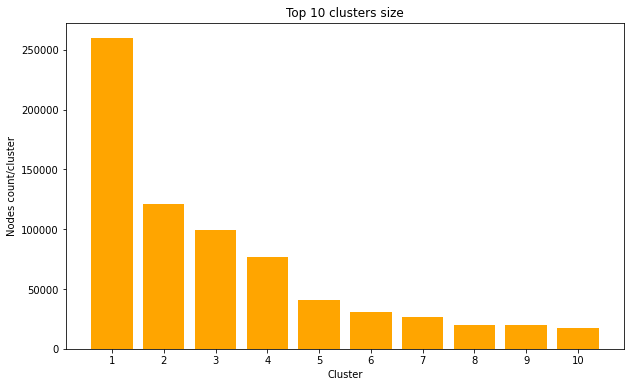

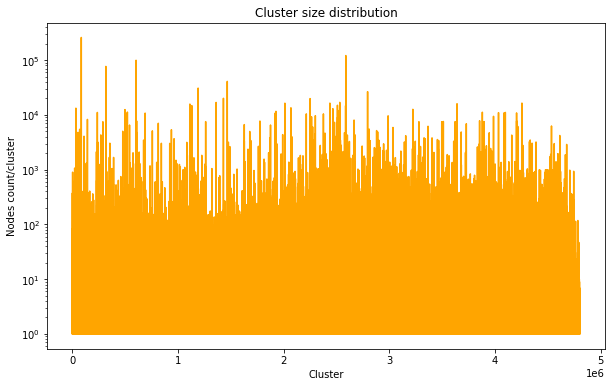

In [ ]:
x_ticks = [i for i in range(1,11)]
plt.figure(figsize=(10, 6))
plt.bar(x_ticks, sorted_clusters_size[:10], color="orange")
plt.title("Top 10 clusters size")
plt.ylabel("Nodes count/cluster")
plt.xticks(x_ticks)
plt.xlabel("Cluster")
plt.show()

# clusters size distribution
plt.figure(figsize=(10, 6))
plt.plot(clusters_size, color="orange")
plt.title("Cluster size distribution")
plt.ylabel("Nodes count/cluster")
plt.xlabel("Cluster")
plt.yscale("log")
plt.show()

# Deanonimizzazione e web scraping

Nell'ultima parte di progetto ho tentato di deanonimizzare i vari cluster, riconducendoli ad un' entita', questo e' possibile grazie ai due siti su cui e' stato fatto scraping. Avendo sviluppato su un computer senza interfaccia grafica ho dovuto installare `webdriver_manager` ed usare un browser headless, specificando delle opzioni al momento di inizializzazione del web driver. Ho specificato anche degli header, come visto a lezione, in modo da non far capire al sito che stavo eseguendo delle richieste con python.

In [ ]:
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium import webdriver
import requests
import time
import bs4

# UBUNTU SERVER
#from selenium.webdriver.chrome.options import Options
#from selenium.webdriver.chrome.service import Service
#from webdriver_manager.chrome import ChromeDriverManager
 
import json

#options = Options()
#options.add_argument('--headless')
#options.add_argument('--no-sandbox')
#options.add_argument('--disable-dev-shm-usage')
#driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
driver = webdriver.Chrome()


# WALLET EXPLORER SCRAPER
header = {"User-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"}


In queste due funzioni ho implementato lo scraping. Nel dizionario salvo le coppie (ClusterX: EntityX). La funzione `get_wallet_expl` prende come parametro un wallet address e tenta di deanonimizzarlo avendo a disposizione 5 tentativi (politica best effort come richiesto). I passi seguiti sono i seguenti:

1. Richiedo la pagina html con il modulo requests, se il codice di ritorno e' 200 (OK) procedo, altrimenti ritento tra due secondi
2. con beautifulSoup faccio il parsing dell'html richiesto, cerco il campo h2 prendendone il testo (valore dell' entita' che detiene il wallet). Questo procedimento lo faccio dato che ho analizzato la pagina web e determinato che il nome dell' entita' e' contenuto all'interno del primo h2. Se `entity` e' definito e non inizia per parentesi quadra significa che l' entita' e' conosciuta e non e' soltanto un id numerico, quindi la ritorno. Se non riesco a trovare il nome dell' entita' ritorno None.

La funzione `scrape_wallet_expl` prende in input i top 10 clusters, itera su ogni cluster e per ogni cluster fa 30 tentativi (visto il numero alto di nodi nel cluster, assumo che se almeno un wallet dovrei deanonimizzarlo senza fare scraping su 60-200k indirizzi per cluster). Iterando in ogni cluster, prendo il valore del wallet dato l'addressId facendo un lookup nel dataframe dei mapping. Infine salvo il risulato ottenuto nel dizionario delle entita' e appena trovo un indirizzo interrompo il loop, passando al cluster successivo (dato che appena deanonimizzo un indirizzo assumo che tutti gli altri nodi siano appartenenti a tale entita', come descritto nell' euristica considerata)

In [ ]:
# dicts to save clusters possible owners
wallet_expl_entities = {}

# WALLET EXPLORER SCRAPER

def get_wallet_expl(address):
    # wallet explorer url f string with address added
    wallet_expl_url = f"https://www.walletexplorer.com/?q={address}"
    retries = 0
    while (retries <= 5):
        retries += 1
        try:
            res = requests.get(wallet_expl_url, headers=header)

            if (res.status_code == 200):
                # read html with beautiful soup
                soup = bs4.BeautifulSoup(res.text, "html.parser")
                entity = soup.find("h2").text
                
                if (entity):
                    # entity is known if wallet is not inside [*]
                    if (not('[' in entity)):
                        return entity.split()[1]
        except:
            pass

        time.sleep(2)
    
    return None

# function to scrape all clusters
def scrape_wallet_expl(clusters):
    
    i = 0
    retries = 0
    for cluster in clusters:

        i+=1
        cluster_name = f"Cluster{i}"
        wallet_expl_entities[cluster_name] = "Not Found"

        for address_id in cluster:
            retries += 1
            if (retries == 30):
                retries = 0
                break

            addr_hash = mapping.loc[mapping['addressId'] == address_id]["hash"].values[0]
            # set owner to None, modify it if found
            wallet_owner = get_wallet_expl(addr_hash)
            
            # wallet owner found, break cycle, save to dict
            if (wallet_owner):
                wallet_expl_entities[cluster_name] = wallet_owner
                break

        print(f"{cluster_name}: {wallet_owner}")

In questa sezione avvio lo scraping e salvo in un json il dizionario con le associazioni (clusterX: EntityX)

In [ ]:
scrape_wallet_expl(top10_clusters)

with open('wallet_expl.json', 'w') as f:
    data = json.dumps(wallet_expl_entities, indent = 1)
    f.write(data)

Per fare scraping di BitcoinInfoCharts ho dovuto usare selenium, seguendo la stessa logica di wallet explorer con unica differenza il modo in cui prendo il nome dell' entita'.

- `get_bitInfoCharts` In questo caso invece di usare requests uso il driver di selenium per navigare sulla pagina, attendere che venga caricata, in particolare attendo di trovare la stringa "wallet: " in quanto contiene il nome dell' entita' cercata. Per attendere imposto una condizione sull' XPATH, ossia una condizione per localizzare la stringa descritta sopra, in particolare `//*[contains(text(), text` cerca text nel documento. Ho quindi passato questa condizione ad una wait sulla condizione, specificando la condizione su cui attendere `EC.presence_of_element_located` ed estrando il testo come nella funzione di wallet explorer. Ottenuta la stringa ho fatto uno split sul ":" e preso l'elemento di indice 1 (dato che split su ":" ritorna -> ["Wallet: ", "entity"])

- `scrape_bitInfo` funziona come `scrape_wallet_expl` soltanto che in questo caso devo controllare che l' entita' ritornata non sia un valore numerico (utilizzando `.isnumeric()`), in tal caso il wallet non e' deanonimizzato. 

In [ ]:
# BIT INFO CHARTS SCRAPER
bitinfo_entities = {}

def get_bitInfoCharts(address):
    # bitcoin info charts url f string with address added
    bitinfo_url = f"https://bitinfocharts.com/bitcoin/address/{address}"
    retries = 0

    while (retries <= 3):
        retries += 1
        # navigate to bitcoinInfoCharts
        driver.get(bitinfo_url)

        try:
            # condition is "wallet: " is in page
            wallet_condition = (By.XPATH, '//*[contains(text(), "wallet: ")]')

            # wait for "wallet: " to load on page
            wallet = WebDriverWait(driver, 10).until(EC.presence_of_element_located(wallet_condition)).text
            # Parse the value as needed
            if "wallet: " in wallet:
                entity = wallet.split(": ")[1]
                return entity

        except:
            pass

        time.sleep(2)
    
    return None

def scrape_bitInfo(clusters):

    i = 0
    for cluster in clusters:
        i+=1
        cluster_name = f"Cluster{i}"

        for address_id in cluster:
            addr_hash = mapping.loc[mapping['addressId'] == address_id]["hash"].values[0]
            # set owner to None, modify it if found
            bitinfo_entities[cluster_name] = "Not Found"
            wallet_owner = get_bitInfoCharts(addr_hash)

            # wallet owner found, break cycle, save to dict
            if ((wallet_owner != None) and (not wallet_owner.isnumeric())):
                bitinfo_entities[cluster_name] = wallet_owner
                break
            else:
                break

        print(f"{cluster_name}: {wallet_owner}")

Avvio la scraper e salvo il risultato come nel caso di wallet explorer

In [ ]:
scrape_bitInfo(top10_clusters)

with open('bitInfo.json', 'w') as f:
    data = json.dumps(bitinfo_entities, indent = 1)
    f.write(data)


In questo progetto ho migliorato la mia conoscenza sul funzionamento di transazioni bitcoin ed ho imparato una tecnica di deanonimizzazione per wallet bitcoin. In particolare ho dedotto che i due siti proposti, visto che forniscono risultati diversi, hanno probabilmente usato euristiche diverse. 

Wallet explorer e' molto piu' lento di BitcoinInfoCharts (motivo per cui ho messo un limite al numero di tentativi per cluster) visto che lasciando in esecuzione lo scraper per un giorno, aveva svolto circa il 40% del lavoro (senza imporre limite al numero di tentativi). Questo penso sia riconducibile al fatto che BitcoinInfoCharts, con alta probabilita', abbia gia' eseguito clustering e fatto labelling per ogni nodo del cluster, in modo che ogni indirizzo sia gia' associato all' entita' di appartenenza, ma questa e' soltanto una mia supposizione per giustificare i tempi di esecuzione. BitcoinInfoCharts impiega pochi secondi rispetto ai molti minuti impiegati da Wallet Explorer, se non si limita il numero di tentativi eseguiti (nel caso in cui non si limiti, andremmo a fare uno scraping esaustivo su ogni elemento del cluster).

Ecco i risultati, rispettivamente per:
- Wallet Explorer

```json
{"Cluster1": "CoinJoinMess",
"Cluster2": "SilkRoadMarketplace",
"Cluster3": "Not Found",
"Cluster4": "Instawallet.org",
"Cluster5": "Not Found",
"Cluster6": "BTC-e.com-old",
"Cluster7": "BtcDice.com",
"Cluster8": "Not Found",
"Cluster9": "Not Found",
"Cluster10": "Not Found"
}

- BitcoinInfoCharts

{"Cluster1": "F2Pool",
"Cluster2": "SilkRoadMarketplace",
"Cluster3": "Not Found",
"Cluster4": "Instawallet.org",
"Cluster5": "Not Found",
"Cluster6": "Eligius",
"Cluster7": "Not Found",
"Cluster8": "Not Found",
"Cluster9": "Not Found",
"Cluster10": "Not Found"
}
```
Un'altra nota importante che ho riscontrato e' che Wallet Explorer molte volte era inaccessibile ritornando la pagina: `Error while querying DB: The table 'antiddos' is full` che risultava in un codice 200 (OK) ma di fatto non contribuiva in nessun modo a deanonimizzare i wallet. Questo non e' dovuto ad un fatto di rate limiting visto che visitando il sito anche da cellulare o altri dispositivi molte volte veniva ritornata questa pagina.

Le entita' deanonimizzate sono riconducibili a servizi presenti durante i primi anni di bitcoin, in particolare:
- [CoinJoinMess](https://en.bitcoin.it/wiki/CoinJoin) era un servizio di aggregazione di transazioni multiple in un' unica transazione per rendere piu' difficile il tracciamento, quindi assumo che i nodi del cluster appartenente a CoinJoin siano probabilmente diverse persone che hanno usato il servizio. In pratica i nodi osservati appartengono effettivamente al cluster CoinJoin ma non sono riconducibili a CoinJoin stesso, bensi' ai suoi utenti.
- SilkRoadMarketplace era un famoso marketplace di oggetti e servizi sul dark web, successivamente chiuso a causa degli oggetti e servizi illegali forniti.
- [InstaWallet](https://en.bitcoin.it/wiki/Instawallet) era un servizio di wallet custodial online che forniva wallet attraverso la loro pagina web, mantenendo le chiave private degli utenti e rendendolo non consigliato rispetto a un wallet non-custodial
- [BTC-e](https://en.wikipedia.org/wiki/BTC-e) BTC-e era un exchange russo per il trading di crypto
- BTC dice era un sito per gioco d'azzardo in cui veniva generato un numero casuale ed in base al valore generato, gli utenti vincevano oppure perdevano
- F2Pool ed Eligius sono due pool di mining di crypto, ossia i miner si collegano tra di loro e contribuiscono ognuno con la propria potenza di calcolo alla pool in modo da avere maggiore probabilita' di successo nel minare un blocco. Il concetto di pool e' utile in quanto ogni miner invia una share della potenza richiesta per minare un blocco e quindi riceve un compenso proporzionale al proprio contributo. Il contributo dipende dalla politica adottata da ogni pool anche se ormai e' comune adottare questo schema nel PoW.